In [1]:
#collecting data
import numpy as np
import scipy.io
mat = scipy.io.loadmat('data500.mat') #dataset_connected_NYCwhile tryin in terminal, start path with Documents

## Preprocessing data

In [2]:
#friendship_new = mat['friendship_new']
friendship_old = mat['new_friendship_old']
selected_checkins = mat['new_checkins']
selected_users_IDs = mat['new_users_IDs']
#temp = mat['selected_venue_IDs']
#selected_venue_IDs = []
#for i in range(len(temp)):
#    temper = temp[i][0]
#    selected_venue_IDs.append(temper[0])
#print(len(selected_venue_IDs)) #sanity check
#print(len(temp)) #should be same as above
#print(max(selected_users_IDs))
#print(len(selected_users_IDs))
print(max(map(max, selected_checkins)))
#print(len(selected_checkins))
#print(max(map(max, friendship_old)))
#print(len(friendship_old))
#max value in friendships should be same or less than the length of user_IDs

11167625


In [3]:
print(np.size(selected_checkins,0))
train_size = int((80/100)*np.size(selected_checkins,0))
print(train_size)
test_size = np.size(selected_checkins,0) - train_size
print(test_size)
train_checkins = selected_checkins[:train_size]
test_checkins = selected_checkins[train_size:]
print(np.size(train_checkins,0))
print(np.size(test_checkins,0))

10375
8300
2075
8300
2075


In [4]:
#print(np.unique(selected_checkins))
#print(selected_checkins)
#print(train_checkins)
#print(test_checkins)
#selected_checkins = train_checkins

In [5]:
# 1. rebuild node index
offset1 = max(selected_checkins[:,0]);
dumy, dumy, n = np.unique(selected_checkins[:,1],return_index=True,return_inverse=True, axis=0)


selected_checkins[:,1] = n+offset1+1; #n is the indices of the unique values in selected_checkins[:,1]
offset2 = max(selected_checkins[:,1]);
dumy, dumy, n = np.unique(selected_checkins[:,2],return_index=True,return_inverse=True, axis=0)

selected_checkins[:,2] = n+offset2+1;
offset3 = max(selected_checkins[:,2]);
dumy, dumy, n = np.unique(selected_checkins[:,3],return_index=True,return_inverse=True, axis=0)
selected_checkins[:,3] = n+offset3+1;

num_node_total = max(map(max, selected_checkins)) #max of the entire matrix = 8117

In [6]:
print(selected_checkins.shape)
print(min(selected_checkins[:,0]))
print(max(selected_checkins[:,0]))
print(min(selected_checkins[:,1]))
print(max(selected_checkins[:,1]))
print(min(selected_checkins[:,2]))
print(max(selected_checkins[:,2]))
print(min(selected_checkins[:,3]))
print(max(selected_checkins[:,3]))

(10375, 4)
1
500
501
667
668
2730
2731
2977


In [7]:
# 2. prepare checkins per user (fast)
#user_chechkins is a cell in MATLAB; using Python List for the same
user_checkins = [[] for _ in range(selected_users_IDs.shape[0])]
user_checkins_counter=np.zeros((len(selected_users_IDs),1)).astype(np.int64)
ind = selected_checkins[:,0].argsort(axis=0)
temp_checkins = np.array([selected_checkins[i,:] for i in ind]) #will not exactly be similar to MATLAB op
u,m,n = np.unique(temp_checkins[:,0],return_index=True,return_inverse=True, axis=0)
m=m.reshape(-1,1)
u=np.array(u)
print(u.shape)
counters = np.vstack((m[1:],temp_checkins.shape[0]))-m #+1 is not there because indexing starts from 0
ini_val=0
for i in range(0,u.shape[0]):
    user_checkins[u[i]-1].append(temp_checkins[ini_val:ini_val+counters[i,0],:])
    user_checkins[u[i]-1]=np.array(user_checkins[u[i]-1])[0,:,:].T
    user_checkins[u[i]-1].astype(np.int64)
    ini_val=ini_val+counters[i,0]
    user_checkins_counter[u[i]-1]=counters[i].astype(np.int64)
print(user_checkins[-1].shape) #for debugging

print(np.count_nonzero(user_checkins_counter)) #for debugging
len(user_checkins_counter)


(481,)
(4, 80)
481


500

In [8]:
# 3. random walk
from scipy.sparse import csr_matrix
num_node = len(selected_users_IDs)
print(num_node)
network=csr_matrix((np.ones((len(friendship_old),)), (friendship_old[:,0]-1, friendship_old[:,1]-1)), shape=(num_node, num_node))
network=network+network.T
#print(network)

node_list=[[] for _ in range(num_node)] #num_node is number of nodes #500 in clipped case
node_list_len = np.zeros((num_node,));
num_walk = 10
len_walk = 80
(indx,indy) = network.T.nonzero()
#for i in range(len(indx)):
#    indx[i]+=1
#    indy[i]+=1

temp, m, n = np.unique(indx,return_index=True,return_inverse=True, axis=0) #check m for debugging
m=np.array(m).reshape(-1,1)
node_list_len=np.vstack((m[1:],len(indx))) - m #+1 is not there because indexing starts from 0
ini_val=0
temp=np.array(temp)
node_list_len=node_list_len[:,0] #for indexing

for i in range(0,temp.shape[0]):
    node_list[temp[i]].append(indy[ini_val:ini_val+node_list_len[i]])
    ini_val=ini_val+node_list_len[i]
#node_list #for debugging match with MATLAB
#node_list_len.shape = np.count_nonzero(node_list_len) has to be as written in MATLAB script


500


In [9]:
#print(indx)
#print(np.unique(indx))
print(np.unique(indx).shape) # should be equal to num_node
print(num_node)

(500,)
500


In [10]:
# let's have a walk over social network (friendship)
import random
walks = np.zeros((num_walk*num_node,len_walk),dtype = np.int64);
for ww in range(num_walk):
    for ii in range(num_node):
        seq = np.zeros((len_walk,),dtype=int)
        seq[0] = ii
        current_e = ii
        for jj in range(len_walk-1):
            rand_ind = random.randint(0, node_list_len[seq[jj]]-1);
            tempvar = node_list[seq[jj]][0] 
            #print(node_list_len[seq[jj]])
            #print(rand_ind)
            #print(tempvar.shape)
            seq[jj+1] = tempvar[rand_ind];
        
        walks[ii+(ww-1)*num_node,:] = seq
        
#preprocessing for removing 0 quantities
for i in range(walks.shape[0]):
    for j in range(walks.shape[1]):
        walks[i,j] = walks[i,j] +1
#print(min(map(min, walks))) #should be 1 and 4024
print(walks)

[[  1  30   1 ... 289 250 409]
 [  2  79 279 ... 109 257 127]
 [  3   3 401 ... 185 461 500]
 ...
 [498 331 198 ... 373  98 234]
 [499 217 206 ... 480  12 389]
 [500   1 457 ... 310  36  68]]


In [11]:
# 4. prepare negative sample table in advance (fast)
# social relationship
from collections import Counter
(dumy,r) = network.nonzero(); #MATLAB gives [y,x]; Python gives (x,y)
print(r.shape)
print(r)
temptab = Counter(r) #len(temptab) = size(tab_degree,1) #Counter gives unique elements in r
tab2= [[] for _ in range(len(temptab))]

for i in range(len(temptab)):
    tab2[i].append(temptab[i])
tab2=np.array(tab2)[:,0] #when printing temptab, not in asc. order but here it becomes asc. wrt keys

tab1=np.unique(r)
tab3=[[] for _ in range(len(tab1))]
tot=sum(tab2)
for i in range(len(tab1)):
    tab3[i]=round((tab2[i]*100)/tot,4)
tab_degree=np.stack((tab1,tab2,tab3),axis=1) # equivalent of tab_degree = tabulate(r) in MATLAB

freq = np.array([round(np.power(i,0.75),4) for i in tab_degree[:,2]] )
den=float(sum(freq))
neg_sam_table_social = np.repeat((1+tab_degree[:,0]),np.around(1000000*freq/sum(freq)).astype(np.int64))
neg_sam_table_social=neg_sam_table_social.astype(np.int64) # unigram with 0.75 power
#neg_sam_table_social[740] check for debugging
del temptab,tab1,tab2,tab3,tab_degree,freq,den
print(neg_sam_table_social)

(5744,)
[  1  23  29 ... 458 460 487]
[  1   1   1 ... 500 500 500]


In [12]:
#checkins: user, venue, time, semantic, with node type normalization for each node domain

neg_sam_table_mobility_norm = [[] for _ in range(4)]
for ii in range(len(neg_sam_table_mobility_norm)):
    tab1=np.array([elem for elem in range(max(temp_checkins[:,ii]))])#tab1 has all elements;even with frequency 0
    temptab = Counter(temp_checkins[:,ii]) #correct
    tab2= np.zeros((len(tab1),))
    for i in tab1:
        tab2[i]= temptab[i+1] #because in python, index starts from 0
    tab2 = np.array(tab2)
    tot=np.sum(tab2)
    tab3=np.zeros((len(tab1),))
    for i in range(len(tab1)):
        tab3[i]= np.round((tab2[i]*100)/tot,4) if (tot) else 0
    tab3=np.array(tab3)
    tab_degree=np.stack((tab1,tab2,tab3),axis=1)
    freq = np.array([np.round(np.power(i,0.75),4) for i in tab_degree[:,2]])
    den=float(sum(freq))
    ingoes = np.repeat((tab_degree[:,0]+1),np.around(100000*freq/sum(freq)).astype(np.int64))
    neg_sam_table_mobility_norm[ii].append(ingoes)

    del tab1,tab2,i,tab3,tab_degree,freq,ingoes,tot

neg_sam_table_mobility_norm = [np.array(x).astype(np.int64) for x in neg_sam_table_mobility_norm]

#neg_sam_table_mobility1 = neg_sam_table_mobility_norm[3][0]
#neg_sam_table_mobility1[5]
print(neg_sam_table_mobility_norm)

[array([[  1,   1,   1, ..., 500, 500, 500]]), array([[501, 501, 501, ..., 667, 667, 667]]), array([[ 668,  668,  668, ..., 2730, 2730, 2730]]), array([[2731, 2731, 2731, ..., 2977, 2977, 2977]])]


In [13]:
print(temp_checkins)
print(np.size(temp_checkins))

[[   1  661 2459 2893]
 [   1  568 1060 2823]
 [   1  590 1115 2784]
 ...
 [ 500  569 2695 2828]
 [ 500  507 1992 2939]
 [ 500  639 1469 2774]]
41500


In [14]:
# LBSN2vec
dim_emb = 2 #128
num_epoch = 1
num_threads =  4
K_neg = 3 #10
win_size = 2 #10
learning_rate = 0.001

embs_ini = (np.random.uniform(size=(num_node_total,dim_emb))-0.5)/dim_emb 
temp = np.sum(np.power(embs_ini,2),axis=1)
embs_len = np.power(temp,0.5)
den = embs_len
for i in range(dim_emb-1):
    den=np.vstack((den,embs_len))
den=den.T
#print(den.shape)
#print(embs_ini.shape)
embs_ini = np.divide(embs_ini,den)

mobility_ratio = 0.2

In [15]:
import learn_LBSN2Vec_embedding

embs = learn_LBSN2Vec_embedding.driver_fn(walks.T,user_checkins, user_checkins_counter,embs_ini.T,learning_rate, 
                                K_neg,neg_sam_table_social, win_size, neg_sam_table_mobility_norm,
                                num_epoch, mobility_ratio);

this is num_w 5000
this is num_wl 80
[[  1   2   3 ... 498 499 500]
 [ 30  79   3 ... 331 217   1]
 [  1 279 401 ... 198 206 457]
 ...
 [289 109 185 ... 373 480 310]
 [250 257 461 ...  98  12  36]
 [409 127 500 ... 234 389  68]]
This is epoch 0
[[ 0.04838622 -0.72745883  0.99199433 ...  0.21755863 -0.73229528
  -0.54984668]
 [-0.9988287  -0.68615133  0.12628244 ... -0.97604726  0.68098725
   0.8352656 ]]


KeyboardInterrupt: 

In [53]:
print(embs.shape)
print(np.min(temp_checkins))
print(np.max(temp_checkins))
print(temp_checkins.shape)
print("this is range of user "+ str(min(temp_checkins[:,0])))
print("this is range of user "+ str(max(temp_checkins[:,0])))
print("this is range of time "+ str(min(temp_checkins[:,1])))
print("this is range of time "+ str(max(temp_checkins[:,1])))
print("this is range of venue_index "+ str(min(temp_checkins[:,2])))
print("this is range of venue_index "+ str(max(temp_checkins[:,2])))
print("this is range of venue_category_index "+ str(min(temp_checkins[:,3])))
print("this is range of venue_category_index "+ str(max(temp_checkins[:,3])))

(2, 341)
1
341
(246, 4)
this is range of user 1
this is range of user 10
this is range of time 11
this is range of time 104
this is range of venue_index 105
this is range of venue_index 267
this is range of venue_category_index 268
this is range of venue_category_index 341


In [56]:
#normalizing

twodemb = np.zeros((embs.shape[1],2))
for i in range(twodemb.shape[0]):
    twodemb[i,0] = embs[0,i]
    twodemb[i,1] = embs[1,i]
    
    
#location prediction on the learnt embeddings
from scipy.spatial import distance

count = 0

for d in range(selected_checkins.shape[0]):
    test = selected_checkins[d]
    user = test[0]
    time = test[1]
    dist = []
    
    for i in range(min(selected_checkins[:,2]),max(selected_checkins[:,2])+1):
        summ = (1 - distance.cosine(twodemb[user-1,:],twodemb[i-1,:]))+(1 - distance.cosine(twodemb[time-1,:],twodemb[i-1,:]))
        dist.append((abs(summ),i))
        
    dist = sorted(dist, key=lambda student: student[0])
    if test[2] in (np.array(dist[0:10])[:,1]):
        count+=1
print("this is count "+str(count))
print("this is count fraction "+str(count/selected_checkins.shape[0]))

this is count 19
this is count fraction 0.07723577235772358


In [23]:
#neg_sam_table_mobility = neg_sam_table_mobility_norm
#neg_sam_table_mobility1 = neg_sam_table_mobility[0][0]
#table_size_mobility1 = neg_sam_table_mobility1.shape
#table_size
x = embs[0]
y = embs[1]
pic = np.zeros(shape = [len(y),2])
pic[:,0]=[i for i in x]
pic[:,1]=[i for i in y]


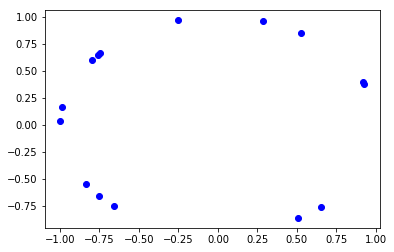

In [26]:
import matplotlib.pyplot as mpp
mpp.plot(x,y,'bo')
